# Logistic Regression Model
### Use model_input_v2.sql
### Features: game_speed, game_distance, anthropometrics (height, weight, body_fat_pct, etc), minutes, usagePercentage, pace, possessions
### Target: is_injured (binary)

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    roc_curve,
)

import os
from sqlalchemy import create_engine

In [75]:
# # RUN THIS TO PULL STRAGITH FROM DB
# THIS IS COMMENTED OUT SINCE YOUR BALL.DB WOULD NOT BE UPDATED
# DB_PATH = "../../../db/BALL.db"  
# DB_FULL_PATH = os.path.abspath(DB_PATH)

# engine = create_engine(f"sqlite:///{DB_FULL_PATH}")

# sql_file = "./model_input_v2.sql"
# if not os.path.exists(sql_file):
#     raise FileNotFoundError(f"SQL file not found: {sql_file}")

# with open(sql_file) as f:
#     sql_query = f.read()

# df = pd.read_sql(sql_query, con=engine)

# display(df.sample(5))

In [76]:
df = pd.read_csv("./model_input_v3.csv")
df.sample(5)

,PLAYER_ID,age,game_id,speed,distance,HEIGHT_WO_SHOES,WEIGHT,WINGSPAN,STANDING_REACH,BODY_FAT_PCT,HAND_LENGTH,HAND_WIDTH,minutes,usagePercentage,pace,possessions,is_injured
5373,201144,28,21500362,4.34,2.70,71.00,175.0,77.75,94.5,4.20,NaN,NaN,37:25,0.215,94.29,74.0,0
17401,203917,23,21501197,4.39,2.79,77.25,206.9,79.75,102.0,12.05,8.5,8.50,36:28,0.205,100.69,77.0,0
14319,203094,27,21500982,4.06,0.53,80.50,234.0,88.00,107.0,7.60,10.0,10.75,7:54,0.143,97.22,16.0,0
10847,2757,34,21500741,4.68,1.15,74.50,199.0,76.50,98.0,9.30,NaN,NaN,14:43,0.273,99.51,30.0,0
8749,203469,24,21500598,4.45,1.69,82.75,230.0,82.75,106.0,4.75,8.5,10.50,22:53,0.163,97.55,46.0,0


In [77]:
print("DataFrame shape:", df.shape)

injured_count = (df['is_injured'] == 1).sum()
print("Count of is_injured = 1:", injured_count)

not_injured_count = (df['is_injured'] == 0).sum()
print("Count of is_injured = 0:", not_injured_count)

DataFrame shape: (17866, 17)
Count of is_injured = 1: 314
Count of is_injured = 0: 17552


In [78]:
# Feature columns: game load (speed, distance), age, anthropometrics, minutes, usagePercentage, pace, possessions
ID_COLS = ["PLAYER_ID", "game_id"]
TARGET = "is_injured"

# Convert minutes from "MM:SS" to numeric (total minutes as float)
def parse_minutes(val):
    if pd.isna(val) or val == "":
        return np.nan
    s = str(val).strip()
    parts = s.split(":")
    if len(parts) == 2:
        return float(parts[0]) + float(parts[1]) / 60.0
    try:
        return float(s)
    except ValueError:
        return np.nan

if "minutes" in df.columns:
    df["minutes"] = df["minutes"].apply(parse_minutes)

feature_cols = [c for c in df.columns if c not in ID_COLS and c != TARGET]
X = df[feature_cols].copy()
y = df[TARGET]

# Coerce all feature columns to numeric (read_sql can return TEXT as object dtype)
for c in X.columns:
    X[c] = pd.to_numeric(X[c], errors="coerce")

# Handle missing values: impute numeric with median
for c in X.select_dtypes(include=[np.number]).columns:
    if X[c].isna().any():
        X[c] = X[c].fillna(X[c].median())

# Drop rows where target is missing (if any)
valid = y.notna()
X, y = X[valid], y[valid].astype(int)

print("Features:", feature_cols)
print("X shape:", X.shape, "| y shape:", y.shape)
print("Target mean (injury rate):", y.mean())

Features: ['age', 'speed', 'distance', 'HEIGHT_WO_SHOES', 'WEIGHT', 'WINGSPAN', 'STANDING_REACH', 'BODY_FAT_PCT', 'HAND_LENGTH', 'HAND_WIDTH', 'minutes', 'usagePercentage', 'pace', 'possessions']
X shape: (17866, 14) | y shape: (17866,)
Target mean (injury rate): 0.01757528265980074


In [79]:
# Train/test split (stratify on binary target for similar injury rate)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print("Train size:", len(y_train), "| Test size:", len(y_test))
print("Train injury rate:", y_train.mean(), "| Test injury rate:", y_test.mean())

Train size: 13399 | Test size: 4467
Train injury rate: 0.017538622285245168 | Test injury rate: 0.017685247369599283


In [ ]:
# Fit logistic regression (class_weight='balanced' for imbalanced injury rate)
model = LogisticRegression(max_iter=3000, random_state=42, class_weight="balanced")
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_prob_train = model.predict_proba(X_train)[:, 1]
y_prob_test = model.predict_proba(X_test)[:, 1]

In [81]:
# Classification metrics
for name, y_true, y_pred, y_prob in [
    ("Train", y_train, y_pred_train, y_prob_train),
    ("Test", y_test, y_pred_test, y_prob_test),
]:
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    print(f"{name}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}, ROC-AUC={auc:.4f}")

print("\nTest set classification report:")
print(classification_report(y_test, y_pred_test, target_names=["not_injured", "injured"]))

Train: Accuracy=0.6728, Precision=0.0362, Recall=0.6894, F1=0.0688, ROC-AUC=0.7271
Test: Accuracy=0.6738, Precision=0.0376, Recall=0.7089, F1=0.0714, ROC-AUC=0.7372

Test set classification report:
              precision    recall  f1-score   support

 not_injured       0.99      0.67      0.80      4388
     injured       0.04      0.71      0.07        79

    accuracy                           0.67      4467
   macro avg       0.51      0.69      0.44      4467
weighted avg       0.98      0.67      0.79      4467



In [82]:
# Predicted vs actual counts
print("Train set - predicted injured:", (y_pred_train == 1).sum())
print("Train set - actual injured:", y_train.sum())
print("Test set - predicted injured:", (y_pred_test == 1).sum())
print("Test set - actual injured:", y_test.sum())

Train set - predicted injured: 4473
Train set - actual injured: 235
Test set - predicted injured: 1490
Test set - actual injured: 79


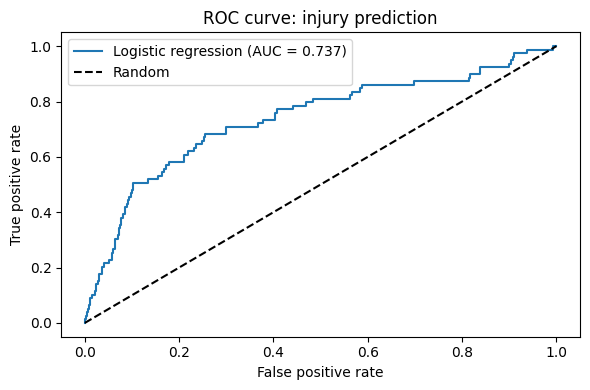

In [83]:
# ROC curve (test set)
fpr, tpr, _ = roc_curve(y_test, y_prob_test)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"Logistic regression (AUC = {roc_auc_score(y_test, y_prob_test):.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.title("ROC curve: injury prediction")
plt.tight_layout()
plt.show()

In [84]:
# Coefficients (log-odds) and odds ratios
intercept = model.intercept_[0] if hasattr(model.intercept_, "__len__") else model.intercept_
coefs = model.coef_.ravel() if model.coef_.ndim > 1 else model.coef_
coef_df = pd.DataFrame({
    "feature": ["(intercept)"] + feature_cols,
    "coefficient": [intercept] + list(coefs),
})
coef_df["odds_ratio"] = np.exp(coef_df["coefficient"])
coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False).drop(columns=["abs_coef"]).reset_index(drop=True)
print(coef_df.to_string(index=False))

        feature  coefficient  odds_ratio
    (intercept)     8.299400 4021.459920
       distance     0.886796    2.427341
    HAND_LENGTH    -0.729019    0.482382
usagePercentage     0.440968    1.554212
          speed    -0.326535    0.721419
     HAND_WIDTH     0.222064    1.248652
HEIGHT_WO_SHOES    -0.097197    0.907377
   BODY_FAT_PCT     0.077536    1.080621
        minutes    -0.047101    0.953991
    possessions    -0.042713    0.958186
       WINGSPAN     0.036342    1.037010
            age     0.010775    1.010834
 STANDING_REACH     0.009420    1.009465
           pace     0.004620    1.004630
         WEIGHT     0.004304    1.004314


## Results and interpretation

### Bottom line
**This model is not useful in practice.** It has weak discriminative power and is not reliable for flagging injury risk.

### What the metrics show
- **Precision ~3–4%:** When the model predicts "injured," it is wrong almost all the time. Too many false positives to trust a positive prediction.
- **ROC-AUC ~0.73:** Modestly better than random (0.5). The features add some signal but not enough for reliable prediction.
- **F1 ~0.07:** Both precision and recall are poor; the "injured" class is not predicted in a usable way.
- **Recall ~66–72%:** The model catches about two-thirds of actual injuries, but at the cost of flagging a large number of non-injured games.

### Why performance is poor
- **Severe class imbalance:** Only ~1.7% of rows are injured. Predicting a rare event with limited predictors is hard even with `class_weight='balanced'`.
- **Limited signal in the features:** Game-level speed, distance, and anthropometrics are weak proxies for injury. Load history, type of movement, and other factors are not in this dataset.
- **Noisy target:** Predicting "is this game an injury game?" is inherently noisy—the same player could be high risk on many games and get injured only once.

### What would help
Richer features (e.g. cumulative load, injury history, sport-specific risk factors), a different target or formulation (e.g. risk over a window, or at player level), or a different model family might improve things. This baseline shows that these features alone are not enough for reliable injury prediction.